In [80]:
import sys
import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch

%matplotlib inline
print(f"Python version: {sys.version}\nNumpy version: {np.__version__}\nMatplotlib version: {matplotlib.__version__}\nPyTorch version: {torch.__version__}")

Python version: 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:49:36) [Clang 16.0.6 ]
Numpy version: 1.26.4
Matplotlib version: 3.8.0
PyTorch version: 2.3.1


# Problem 1

## Setup (given)

In [81]:
N, p = 30, 20
np.random.seed(0)
X = np.random.randn(N,p)
Y = 2*np.random.randint(2, size = N) - 1
lamda = 30

## Training

In [82]:
theta = 0.1 * np.random.randn(p)
phi = 0.1 * np.random.randn(p)
alpha = 3e-1
beta = 1e-4

epoch = 5000
L_val = []
d_phi_val = []
d_theta_val = []

for _ in range(epoch):
    for __ in range(N):
        # Use alternating stochastic gradient ascent-descent
        i = np.random.randint(N)  # stochastic so choose random index of gradient to descend/ascend
        stoc_d_phi = (Y[i] * theta) / (1 + np.exp(Y[i] * ((X[i,:]-phi) @ theta))) - lamda * phi
        phi += beta*stoc_d_phi
        
        # uses updated phi value
        stoc_d_theta = Y[i]*(phi-X[i,:]) / (1 + np.exp(Y[i] * ((X[i,:]-phi) @ theta)))
        theta -= alpha*stoc_d_theta

    L_i = np.average(np.log(1 + np.exp(-Y * ((X - phi.reshape(1,-1)) @ theta)))) - lamda/2 * np.linalg.norm(phi, axis=0, ord=2) **2
    d_phi = np.average(Y / (1 + np.exp(Y * ((X-phi.reshape(1,-1)) @ theta)))) * theta - lamda * phi
    d_theta = np.average(( -Y / (1 + np.exp(Y * ((X-phi.reshape(1,-1)) @ theta))) ).reshape(-1,1)*(X-phi.reshape(1,-1)), axis=0)

    L_val.append(L_i)
    d_phi_val.append(d_phi)
    d_theta_val.append(d_theta)

## Plot results

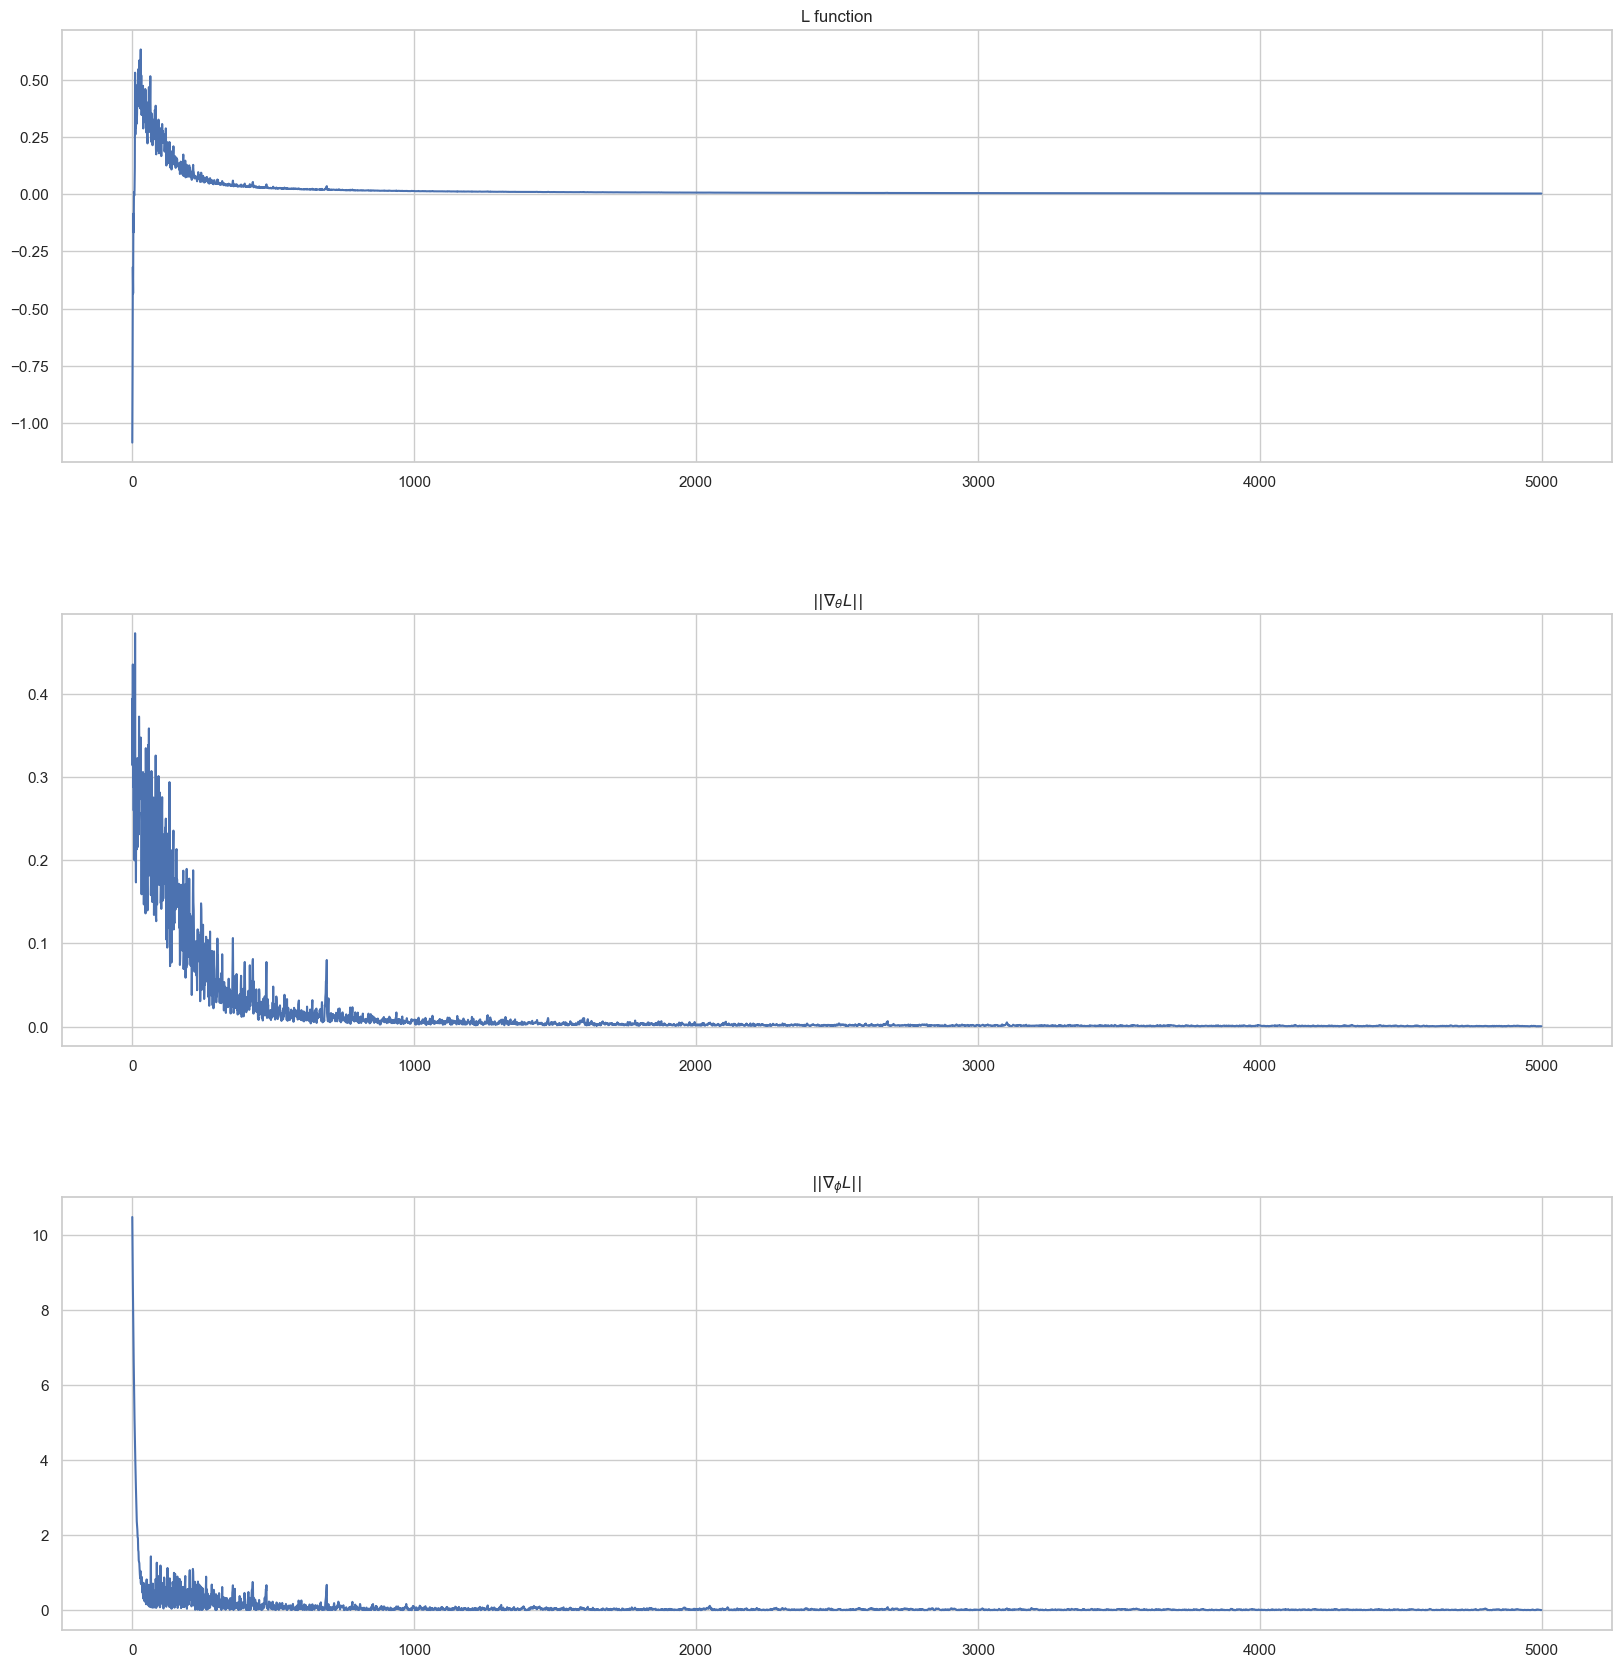

In [83]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 20))
plt.subplots_adjust(left=0.125,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.35)

ax1.set_title("L function")
ax1.plot(L_val)

ax2.set_title(r"$||\nabla_\theta L||$")
ax2.plot(np.linalg.norm(d_theta_val, axis=1, ord=2))

ax3.set_title(r"$||\nabla_\phi L||$")
ax3.plot(np.linalg.norm(d_phi_val, axis=1, ord=2))

plt.show()

# Problem 3

## Given setup and dataset

In [21]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

torch.random.manual_seed(0)
batch_size = 64
learning_rate = 5e-4
num_epochs = 2000  # given in exercise
device = "cpu"
# device = "mps" # "cuda:0" if torch.cuda.is_available() else "cpu"

In [22]:
def make_swiss_roll(n_samples=2000, noise = 1.0, dimension = 2, a = 20, b = 5):
    """
    Generate 2D swiss roll dataset 
    """
    t = 2 * np.pi * np.sqrt(np.random.uniform(0.25,4,n_samples))

    X = 0.1 * t * np.cos(t)
    Y = 0.1 * t * np.sin(t)

    errors = 0.025 * np.random.multivariate_normal(np.zeros(2), np.eye(dimension), size = n_samples)
    X += errors[:, 0]
    Y += errors[:, 1]
    return np.stack((X, Y)).T

class SwissRollDataset(Dataset) :
    def __init__(self, data) :
        super().__init__()
        self.data = torch.from_numpy(data).to(torch.float32)  # to allow for running on mps

    def __len__(self) :
        return len(self.data)

    def __getitem__(self, idx) :
        return self.data[idx]

def show_data(data, title, levels=1000):
    """
    Plot the data distribution
    """
    sns.set(rc={'axes.facecolor': 'honeydew', 'figure.figsize': (5.0, 5.0)})
    plt.figure(figsize = (5, 5))
    plt.rc('text', usetex = False)
    plt.rc('font', family = 'serif')
    plt.rc('font', size = 10)

    g = sns.kdeplot(x=data[:, 0], y=data[:, 1], fill=True, thresh=0.1, levels=levels, cmap="Greens")

    g.grid(False)
    plt.margins(0, 0)
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.title(title + f' (levels={levels})')
    plt.show()

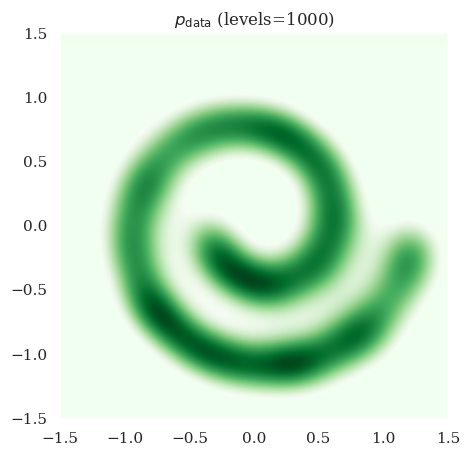

In [23]:
data = make_swiss_roll()
show_data(data, r"$p_\text{data}$")

In [24]:
dataset = SwissRollDataset(data)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Implement models

In [56]:
class Encoder(nn.Module):
    def __init__(self, input_dim=2, hidden_width=128):
        super(Encoder,self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(input_dim, hidden_width),
                                 nn.LeakyReLU(0.2))
        self.fc2 = nn.Sequential(nn.Linear(hidden_width, hidden_width),
                                 nn.Tanh())
        self.fc3 = nn.Linear(hidden_width, 2)
        
    def forward(self, x):
        x = self.fc1(x.float())
        x = self.fc2(x)
        x = self.fc3(x)
        mu, log_std = x[:,0], x[:,1]
        return mu, log_std

class Decoder(nn.Module):
    def __init__(self, input_dim=1, hidden_width=64):
        super(Decoder,self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.Sequential(nn.Linear(input_dim, hidden_width),
                                 nn.LeakyReLU(0.2))
        self.fc2 = nn.Sequential(nn.Linear(hidden_width, hidden_width),
                                 nn.Tanh())
        self.fc3 = nn.Linear(hidden_width, 2)

    def forward(self, z):
        z = z.float().view(-1, self.input_dim)
        z = self.fc1(z)
        z = self.fc2(z)
        return self.fc3(z)

## Train model

In [57]:
Encoder = Encoder().to(device)
Decoder = Decoder().to(device)
optimizer = torch.optim.Adam(list(Encoder.parameters()) + list(Decoder.parameters()), lr=learning_rate)
F_THETA_SIGMA = 1/torch.sqrt(torch.tensor(150))  # referred to as reg_coeff in solutions (set to 150 and multiplied directly at loss calculation)

In [58]:
# -log_p_theta_(x|z) (reconstruction loss)
def log_p(x, mu, log_std, sigma=F_THETA_SIGMA):
    # mu, log_std = Encoder(x)
    z = mu + log_std.exp()*torch.randn_like(mu)  # re-parametrisation trick
    mse = nn.MSELoss().to(device)
    x_hat = Decoder(z)
    return mse(x, x_hat)/torch.square(sigma)

# KL-divergence terms (regularisation loss)
def kl_div(mu, log_std):
    # mu, log_std = Encoder(x)
    return torch.mean(log_std.exp().square() + mu**2 - 2*log_std)  # tr(var) + ||u||^2 - log(det(var)) (slide 79)

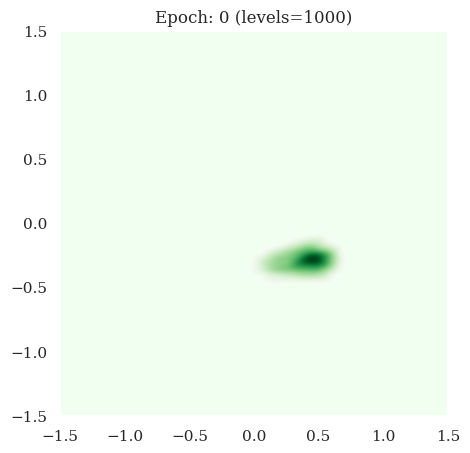

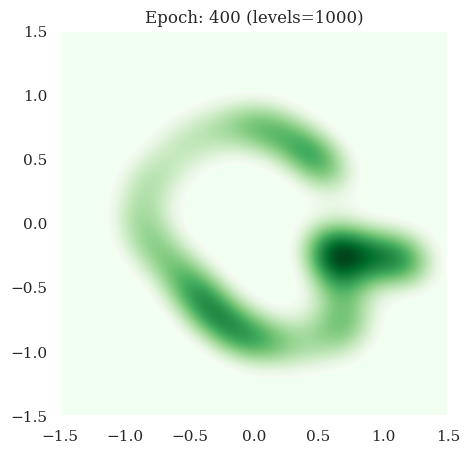

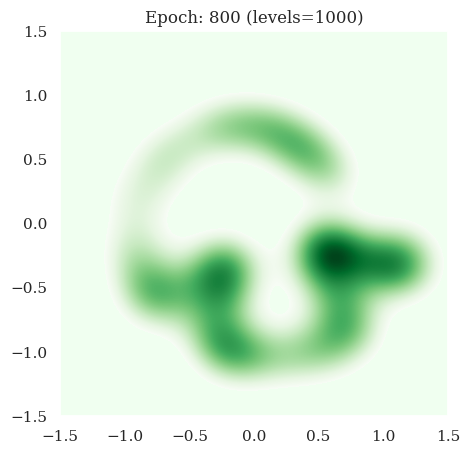

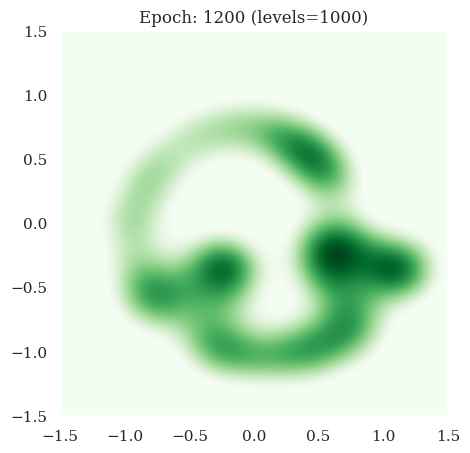

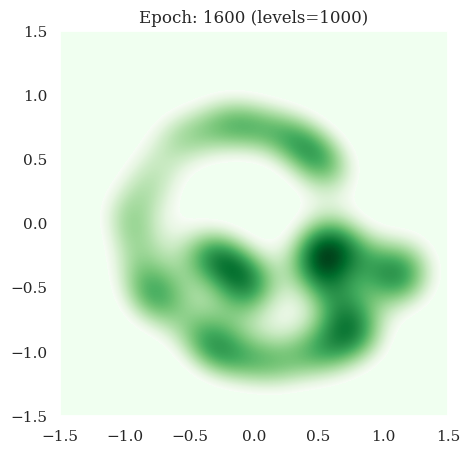

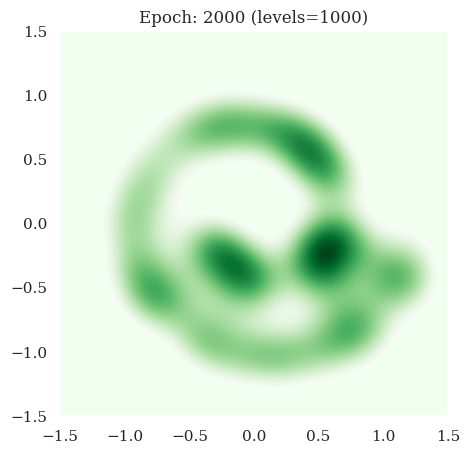

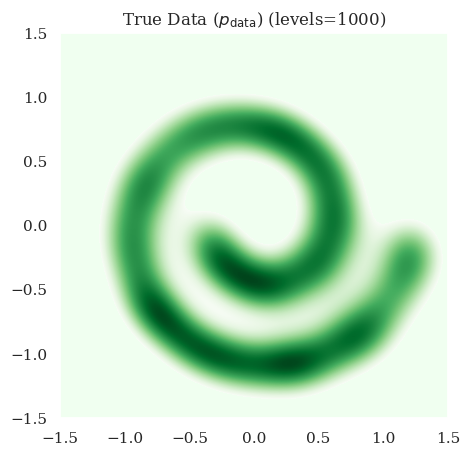

In [59]:
def sample_and_show(epoch_num, num_samples=2000):
    z = torch.randn((num_samples,)).to(device)
    f_theta = Decoder(z)
    # solutions don't use this extra resampling since it just wants to see training progress
    # this is essentially just another normal sampling on top that has mean of f_theta anyway
    x = torch.normal(f_theta, F_THETA_SIGMA * torch.ones_like(f_theta)).cpu()

    show_data(x.detach().numpy(), f"Epoch: {epoch_num}")
    
for epoch in range(num_epochs):
    # Visualize the intermediate result
    if epoch % (num_epochs // 5) == 0:
        sample_and_show(epoch)
        
    for x in loader:
        if device == "cpu" :
            x = x.to(device).type(torch.FloatTensor)
        elif device == "mps":
            x = x.to(device).type(torch.mps.Tensor)
            
        x = x.to(device)
        mu, log_std = Encoder(x)
    
        loss = log_p(x, mu, log_std) + kl_div(mu, log_std)
    
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
sample_and_show(num_epochs)
show_data(data, r"True Data ($p_\text{data}$)")

# Problem 4

In [72]:
torch.random.manual_seed(0)
num_epochs = 2000
dataset = SwissRollDataset(make_swiss_roll())
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Implement models

In [73]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=2, hidden_width=128):
        super(Discriminator,self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(input_dim, hidden_width),
                                 nn.Tanh())
        self.fc2 = nn.Sequential(nn.Linear(hidden_width, hidden_width),
                                 nn.Tanh())
        self.fc3 = nn.Sequential(nn.Linear(hidden_width, 1),
                                 nn.Sigmoid())
        
    def forward(self, x):
        x = self.fc1(x.float())
        x = self.fc2(x)
        x = self.fc3(x)
        return x

class Generator(nn.Module):
    def __init__(self, input_dim=1, hidden_width=32):
        super(Generator,self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(input_dim, hidden_width),
                                 nn.Tanh())
        self.fc2 = nn.Linear(hidden_width, 2)

    def forward(self, z):
        z = z.float().view(-1, 1)
        z = self.fc1(z)
        z = self.fc2(z)
        return z

## Train model

In [74]:
D = Discriminator().to(device)
G = Generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)

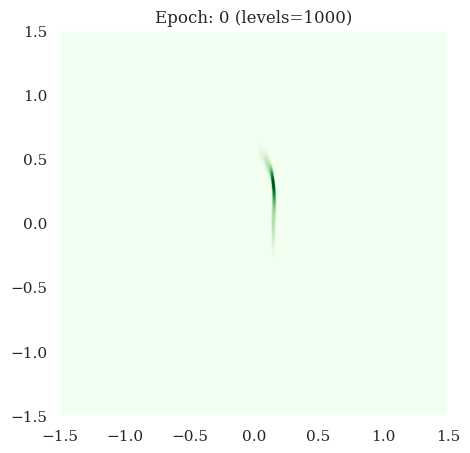

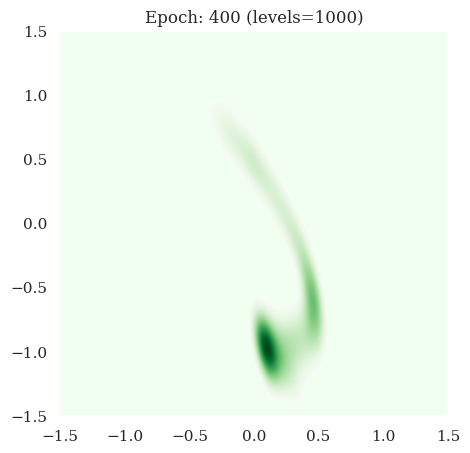

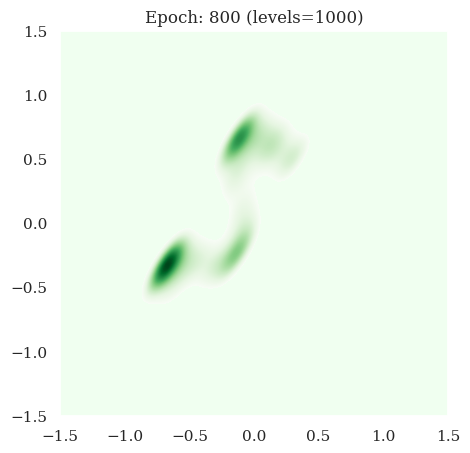

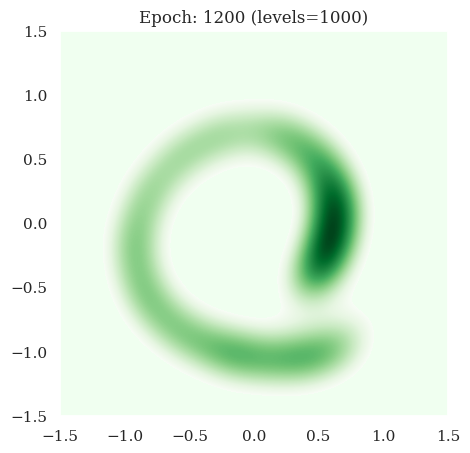

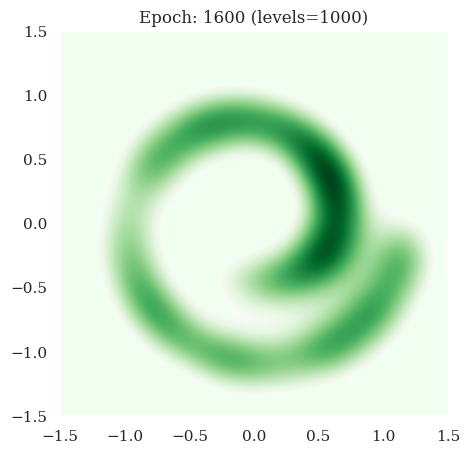

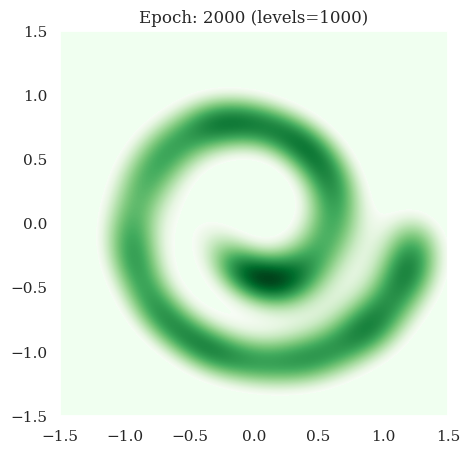

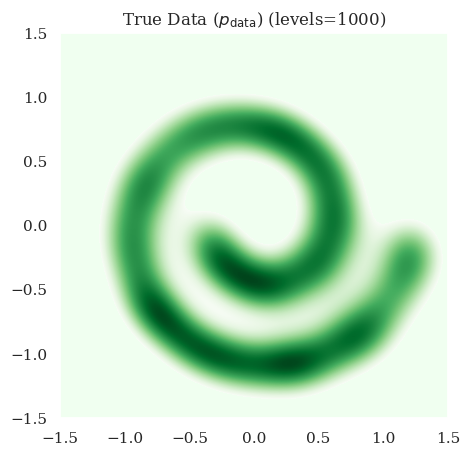

In [75]:
def sample_and_show(epoch_num, num_samples=2000):
    z = torch.randn((num_samples,1)).to(device)
    generated = G(z)
    levels = 1000
    while levels > 0:
        try:
            # data starts off much more bunched so fewer levels required to avoid "Contour levels must be increasing" error
            show_data(generated.detach().numpy(), f"Epoch: {epoch_num}", levels=levels)
        except ValueError:
            levels -= 100
        finally:
            return
        
    raise ValueError("Failed to find an appropriate levels value for sns.kdeplot that allowed data to be drawn")
    
for epoch in range(num_epochs):
    # Visualize the intermediate result
    if epoch % (num_epochs // 5) == 0:
        sample_and_show(epoch)
        
    for x in loader:
        x.to(device)
        
        # use alternating ascent descent GD
        D.zero_grad()  # seems to have better performance than _optimizer
        # see https://stackoverflow.com/questions/61898668/net-zero-grad-vs-optim-zero-grad-pytorch
        D_type_1_loss = torch.mean(torch.log(D(x)))
        z = torch.randn((batch_size, 1)).to(device)
        D_type_2_loss = torch.mean(torch.log(1-D(G(z))))
        D_loss = -(D_type_1_loss + D_type_2_loss)  # maximise
        D_loss.backward()
        D_optimizer.step()
        
        G.zero_grad()  # seems to have better performance than _optimizer
        z = torch.randn((batch_size, 1)).to(device)
        G_loss = torch.mean(torch.log(1-D(G(z))))  # minimise
        G_loss.backward()
        G_optimizer.step()
        
        
sample_and_show(num_epochs)
show_data(data, r"True Data ($p_\text{data}$)")